In [49]:
from utils import *
import pandas as pd
import numpy as np
from post_process import PostProcess
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter

font_size = 14
label_font_size = 18

font_style = "Arial"
mpl.rcParams['font.family'] = font_style
mpl.rcParams['font.size'] = font_size 

# Load systematic data

In [50]:
annual_maxima_csv = r"C:\ISYE6420\Homework\Project\data\OC_Dam.csv"

df = pd.read_csv(annual_maxima_csv)
df["zstd"] = -norm.ppf(df["Plotting_Position"])
data = df["Flow"].to_xarray()

time_index = np.arange(len(data))

## Define quantiles for calculation

In [51]:
quantiles = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 
             0.9, 0.95, 0.98, 0.99, 0.995, 0.999, 0.9995, 0.9998,
             0.9999, 0.99995, 0.99998, 0.99999, 0.999995, 0.999998, 
             0.999999] 

x_values_z_scores = [-norm.ppf(1 - x) for x in quantiles]

## Stationary

In [52]:
samples_csv = r"C:\ISYE6420\Homework\Project\data\OCD\OCD_bayesian_stationary_lp3_summaries.csv"
summaries_lp3 = pd.read_csv(samples_csv)
posterior_mode = summaries_lp3.loc[summaries_lp3['LogLikelihood'].idxmax()]
mu_slp3 = posterior_mode['mu']
sigma_slp3 = posterior_mode['sigma']
gamma_slp3 = posterior_mode['gamma']
print("\nPosterior mode:\n")
print(f"mu: {mu_slp3}")
print(f"sigma: {sigma_slp3}")
print(f"gamma: {gamma_slp3}")

# Calculate the quantiles for the LP3 distribution
flood_quantiles_slp3 = [lp3_ppf(p, mu=mu_slp3, sigma=sigma_slp3, gamma_val=gamma_slp3) for p in quantiles]


Posterior mode:

mu: 1.302558936058672
sigma: 0.6994182638972732
gamma: 0.1778301048768925


In [53]:
df_samples_s = pd.read_csv(samples_csv)

pp = PostProcess(df_samples_s, quantiles)
df_posterior_s = pp.calculate_posterior_predictive_and_CI_df()

# Assign the values to variables
posterior_predictive_s = df_posterior_s["posterior_predictive"].values
lower_ci_s = df_posterior_s["percentile_5"].values
upper_ci_s = df_posterior_s["percentile_95"].values

## Non-stationary: $\mu$ linear tend

### Define selected year for analysis

In [54]:
selected_year = 1949
start_year = 1915

### Posterior mode

In [55]:
ns_samples_csv = r"C:\ISYE6420\Homework\Project\data\OCD\OCD_bayesian_linear_mu_lp3_summaries.csv"
ns_summaries_lp3 = pd.read_csv(ns_samples_csv)
ns_posterior_mode = ns_summaries_lp3.loc[ns_summaries_lp3['LogLikelihood'].idxmax()]
beta0_nslp3 = ns_posterior_mode['beta_0']
beta1_nslp3 = ns_posterior_mode['beta_1']
sigma_nslp3 = ns_posterior_mode['sigma']
gamma_nslp3 = ns_posterior_mode['gamma']
print("\nPosterior mode:\n")
print(f"beta0: {beta0_nslp3}")
print(f"beta1: {beta1_nslp3}")
print(f"sigma: {sigma_nslp3}")
print(f"gamma: {gamma_nslp3}")



Posterior mode:

beta0: 1.86863297966136
beta1: -0.0107855759812721
sigma: 0.6138861848795376
gamma: -0.0476128134548506


In [56]:
# Calculate the quantiles for the LP3 distribution
mu_nslp3 = beta0_nslp3 + beta1_nslp3 * (selected_year-start_year)
flood_quantiles_nslp3 = [lp3_ppf(p, mu=mu_nslp3, sigma=sigma_nslp3, gamma_val=gamma_nslp3) for p in quantiles]

### Posterior predictive and credible intervals

In [57]:
df_samples = pd.read_csv(ns_samples_csv)
df_samples["mu"] = df_samples["beta_0"] + df_samples["beta_1"] * (selected_year-start_year)

pp = PostProcess(df_samples, quantiles)
df_posterior = pp.calculate_posterior_predictive_and_CI_df()

In [58]:
# Assign the values to variables
posterior_predictive = df_posterior["posterior_predictive"].values
lower_ci = df_posterior["percentile_5"].values
upper_ci = df_posterior["percentile_95"].values

### Load bestfit result

In [59]:
bf_beta0_nslp3 = 1.87144779610585
bf_beta1_nslp3 = -0.010907877041711
bf_sigma_nslp3 = 0.612570601649978
bf_gamma_nslp3 = -0.0469348594959537

bf_mu_nslp3 = bf_beta0_nslp3 + bf_beta1_nslp3 * (selected_year-start_year)
flood_quantiles_bf_nslp3 = [lp3_ppf(p, mu=bf_mu_nslp3, sigma=bf_sigma_nslp3, gamma_val=bf_gamma_nslp3) for p in quantiles]

In [60]:
output_csv = r"C:\ISYE6420\Homework\Project\data\OCD\OCD_bestfit_output_mu_linear.csv"

df_bestfit = pd.read_csv(output_csv)

bestfit_aep = df_bestfit["AEP"].values
bestfit_aep = bestfit_aep[~np.isnan(bestfit_aep)]
bestfit_z_scores = [-norm.ppf(x) for x in bestfit_aep]

bestfit_mode = df_bestfit["Posterior Mode"].values
bestfit_mode = bestfit_mode[~np.isnan(bestfit_mode)]

bestfit_predicitive = df_bestfit["Posterior Predictive"].values
bestfit_predicitive = bestfit_predicitive[~np.isnan(bestfit_predicitive)]

bestfit_5CI = df_bestfit["5.0% CI"].values
bestfit_5CI = bestfit_5CI[~np.isnan(bestfit_5CI)]

bestfit_95CI = df_bestfit["95.0% CI"].values
bestfit_95CI = bestfit_95CI[~np.isnan(bestfit_95CI)]

### Plot distribution

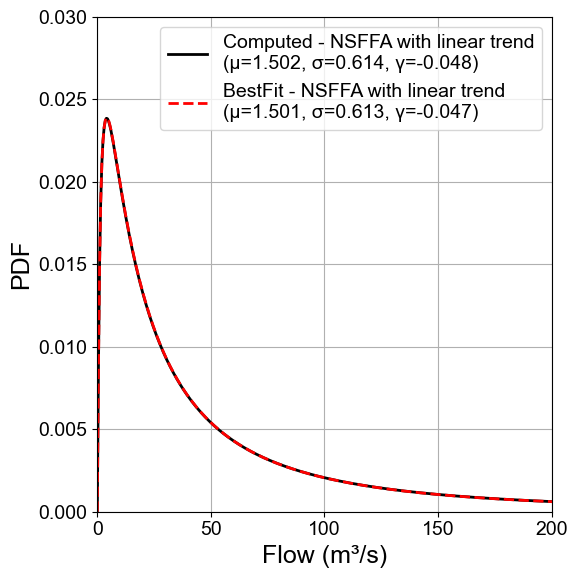

In [61]:
x_values = np.linspace(0.01, 500, 1000)
lp3_pdf_values_ns = lp3_pdf(x_values, mu=mu_nslp3, sigma=sigma_nslp3, gamma_val=gamma_nslp3)
lp3_pdf_values_bestfit = lp3_pdf(x_values, mu=bf_mu_nslp3, sigma=bf_sigma_nslp3, gamma_val=bf_gamma_nslp3)

# Plotting the PDF
plt.figure(figsize=(6, 6))
plt.plot(x_values, lp3_pdf_values_ns, 
         color = "black",  linewidth=2,
         label=f"Computed - NSFFA with linear trend\n(μ={mu_nslp3:.3f}, σ={sigma_nslp3:.3f}, γ={gamma_nslp3:.3f})")
plt.plot(x_values, lp3_pdf_values_bestfit, 
         color = "red", linestyle='--', linewidth=2,
         label=f"BestFit - NSFFA with linear trend\n(μ={bf_mu_nslp3:.3f}, σ={bf_sigma_nslp3:.3f}, γ={bf_gamma_nslp3:.3f})")

plt.xlim(0, 200)
plt.ylim(0, 0.03)
plt.xlabel("Flow (m³/s)", fontsize=label_font_size, fontname=font_style)
plt.ylabel("PDF", fontsize=label_font_size, fontname=font_style)
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig(r"C:\ISYE6420\Homework\Project\data\OCD\OCD_LP3_linear_mu_comparison.png", dpi=300)

### Plot flood frequency curve

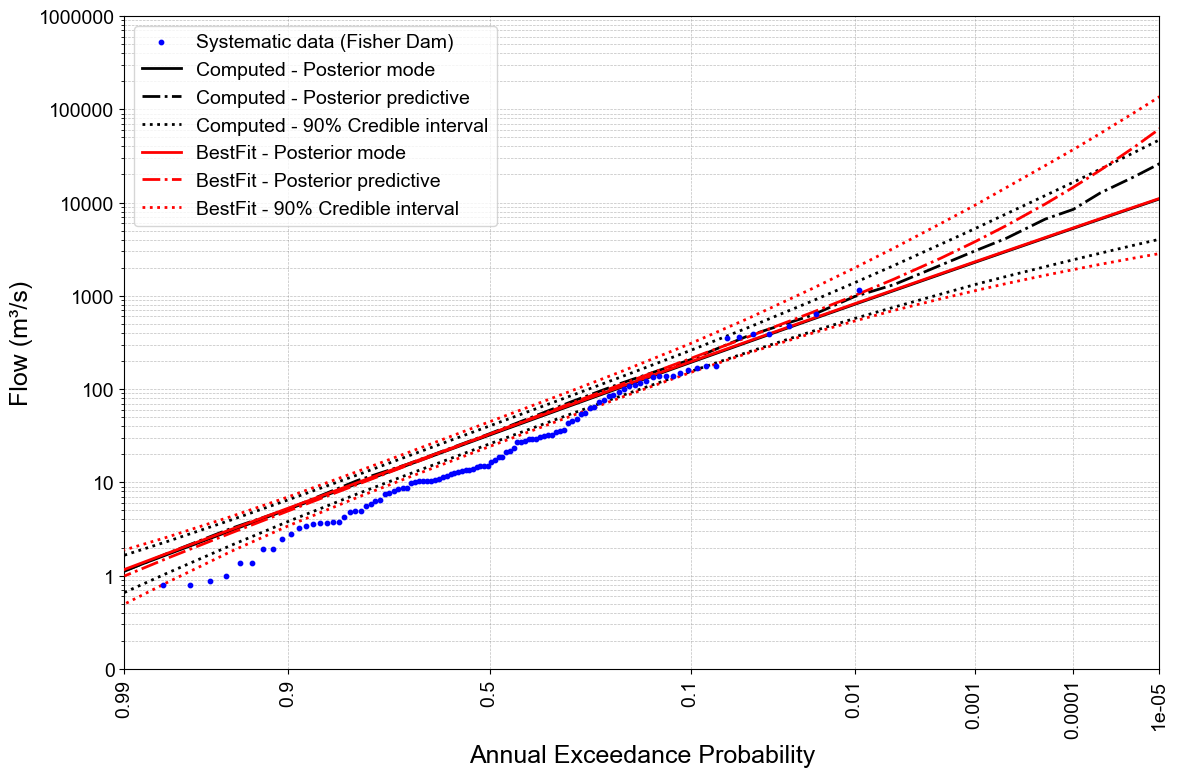

In [62]:
plt.figure(figsize=(12, 8))

plt.scatter(df['zstd'], df['Flow'], 
            s=10, color='blue', label='Systematic data (Fisher Dam)', zorder=10)


plt.plot(x_values_z_scores, flood_quantiles_nslp3, 
         color = "black", linewidth=2,
         label=f"Computed - Posterior mode")

plt.plot(x_values_z_scores, posterior_predictive, 
         color = "black", linestyle='-.', linewidth=2,
         label=f"Computed - Posterior predictive", zorder = 8)

plt.plot(x_values_z_scores, lower_ci, 
         color = "black", linestyle='dotted', linewidth=2,
         label = "Computed - 90% Credible interval")

plt.plot(x_values_z_scores, upper_ci, 
         color = "black", linestyle='dotted', linewidth=2)

plt.plot(bestfit_z_scores, bestfit_mode, 
         color = "red",  linewidth=2,
         label=f"BestFit - Posterior mode", zorder = 9)

plt.plot(bestfit_z_scores, bestfit_predicitive, 
         color = "red", linestyle='-.', linewidth=2,
         label=f"BestFit - Posterior predictive", zorder = 9)

plt.plot(bestfit_z_scores, bestfit_5CI, 
         color = "red", linestyle='dotted', linewidth=2,
         label=f"BestFit - 90% Credible interval", zorder = 9)

plt.plot(bestfit_z_scores, bestfit_95CI, 
         color = "red", linestyle='dotted', linewidth=2, zorder = 9)

# cut off values for major ticks, and their corresponding z-scores
aep_lst = [0.99, 0.9, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001]
major_z_scores = [-norm.ppf(aep) for aep in aep_lst]
x_ticks = [str(aep) for aep in aep_lst]

plt.xticks(major_z_scores, x_ticks, rotation = 90)
plt.grid(which='both', color='grey', linestyle='--', linewidth=0.5, alpha=0.5)

plt.yscale('log')
y_values = [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]
y_ticks = [str(i) for i in y_values]
plt.yticks(y_values, y_ticks)

plt.xlim(major_z_scores[0], major_z_scores[-1])
plt.ylim(y_values[0], y_values[-1])

ax = plt.gca()
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter) 

# set labels for x and y axes
plt.xlabel('Annual Exceedance Probability', fontsize=label_font_size, fontname=font_style)
plt.ylabel("Flow (m³/s)", fontsize=label_font_size, fontname=font_style)
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig(r"C:\ISYE6420\Homework\Project\data\OCD\OCD_bayesian_flood_quantiles_lp3_linear_mu.png", dpi=300)

## Non-stationary: $\mu$ exponential tend

### Posterior mode

In [63]:
ns_exp_samples_csv = r"C:\ISYE6420\Homework\Project\data\OCD\OCD_bayesian_exponential_mu_lp3_summaries.csv"
ns_exp_summaries_lp3 = pd.read_csv(ns_exp_samples_csv)
ns_exp_posterior_mode = ns_exp_summaries_lp3.loc[ns_exp_summaries_lp3['LogLikelihood'].idxmax()]
beta0_exp_nslp3 = ns_exp_posterior_mode['beta_0']
beta1_exp_nslp3 = ns_exp_posterior_mode['beta_1']
sigma_exp_nslp3 = ns_exp_posterior_mode['sigma']
gamma_exp_nslp3 = ns_exp_posterior_mode['gamma']
print("\nPosterior mode:\n")
print(f"beta0: {beta0_exp_nslp3}")
print(f"beta1: {beta1_exp_nslp3}")
print(f"sigma: {sigma_exp_nslp3}")
print(f"gamma: {gamma_exp_nslp3}")



Posterior mode:

beta0: 1.934486074239904
beta1: -0.008112611740471
sigma: 0.6187427418234042
gamma: -0.0345025804728167


In [64]:
# Calculate the quantiles for the LP3 distribution
mu_exp_nslp3 = beta0_exp_nslp3 * np.exp(beta1_exp_nslp3 * (selected_year-start_year))
flood_quantiles_nslp3_exp = [lp3_ppf(p, mu=mu_exp_nslp3, sigma=sigma_exp_nslp3, gamma_val=gamma_exp_nslp3) for p in quantiles]

### Posterior predictive and credible intervals

In [65]:
df_samples_exp = pd.read_csv(ns_exp_samples_csv)
df_samples_exp["mu"] = df_samples_exp["beta_0"]* np.exp(df_samples_exp["beta_1"] * (selected_year-start_year))

pp_exp = PostProcess(df_samples_exp, quantiles)
df_posterior_exp = pp_exp.calculate_posterior_predictive_and_CI_df()

In [66]:
# Assign the values to variables
posterior_predictive_exp = df_posterior_exp["posterior_predictive"].values
lower_ci_exp = df_posterior_exp["percentile_5"].values
upper_ci_exp = df_posterior_exp["percentile_95"].values

### Load BestFir result

In [67]:
bf_beta0_nslp3_exp = 1.9552929765164
bf_beta1_nslp3_exp = -0.00832115537941054
bf_sigma_nslp3_exp = 0.613426319621828
bf_gamma_nslp3_exp = -0.0306512792460451


bf_mu_nslp3_exp = bf_beta0_nslp3_exp* np.exp(bf_beta1_nslp3_exp * (selected_year-start_year))
flood_quantiles_bf_nslp3_exp = [lp3_ppf(p, mu=bf_mu_nslp3_exp, sigma=bf_sigma_nslp3_exp, gamma_val=bf_gamma_nslp3_exp) for p in quantiles]

output_csv = r"C:\ISYE6420\Homework\Project\data\OCD\OCD_bestfit_output_mu_exponential.csv"

df_bestfit_exp = pd.read_csv(output_csv)

bestfit_aep_exp = df_bestfit_exp["AEP"].values
bestfit_aep_exp = bestfit_aep_exp[~np.isnan(bestfit_aep_exp)]
bestfit_z_scores_exp = [-norm.ppf(x) for x in bestfit_aep_exp]

bestfit_mode_exp = df_bestfit_exp["Posterior Mode"].values
bestfit_mode_exp = bestfit_mode_exp[~np.isnan(bestfit_mode_exp)]

bestfit_predicitive_exp = df_bestfit_exp["Posterior Predictive"].values
bestfit_predicitive_exp = bestfit_predicitive_exp[~np.isnan(bestfit_predicitive_exp)]

bestfit_5CI_exp = df_bestfit_exp["5.0% CI"].values
bestfit_5CI_exp = bestfit_5CI_exp[~np.isnan(bestfit_5CI_exp)]

bestfit_95CI_exp = df_bestfit_exp["95.0% CI"].values
bestfit_95CI_exp = bestfit_95CI_exp[~np.isnan(bestfit_95CI_exp)]

### Plot distribution

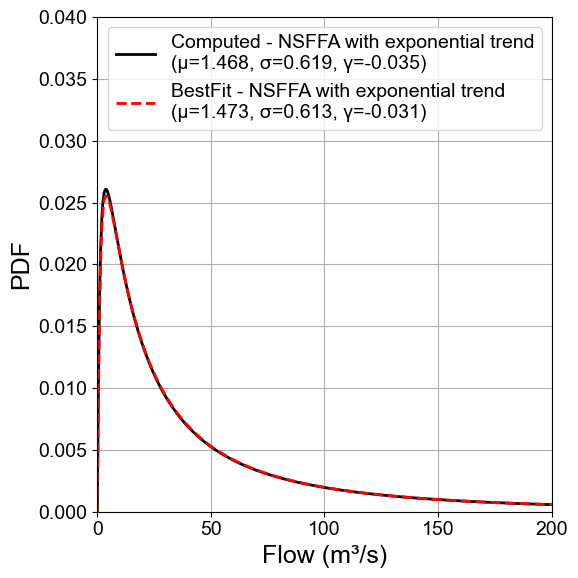

In [68]:
x_values = np.linspace(0.01, 500, 1000)
lp3_pdf_values_ns = lp3_pdf(x_values, mu=mu_nslp3, sigma=sigma_nslp3, gamma_val=gamma_nslp3)
lp3_pdf_values_exp = lp3_pdf(x_values, mu=mu_exp_nslp3, sigma=sigma_exp_nslp3, gamma_val=gamma_exp_nslp3)
lp3_pdf_values_s = lp3_pdf(x_values, mu=mu_slp3, sigma=sigma_slp3, gamma_val=gamma_slp3)
lp3_pdf_values_bf_exp = lp3_pdf(x_values, mu=bf_mu_nslp3_exp, sigma=bf_sigma_nslp3_exp, gamma_val=bf_gamma_nslp3_exp)

# Plotting the PDF
plt.figure(figsize=(6, 6))
plt.plot(x_values, lp3_pdf_values_exp, 
         color = "black",  linewidth=2,
         label=f"Computed - NSFFA with exponential trend\n(μ={mu_exp_nslp3:.3f}, σ={sigma_exp_nslp3:.3f}, γ={gamma_exp_nslp3:.3f})")
plt.plot(x_values, lp3_pdf_values_bf_exp, 
         color = "red", linestyle='--', linewidth=2,
         label=f"BestFit - NSFFA with exponential trend\n(μ={bf_mu_nslp3_exp:.3f}, σ={bf_sigma_nslp3_exp:.3f}, γ={bf_gamma_nslp3_exp:.3f})")

plt.xlim(0, 200)
plt.ylim(0, 0.04)
plt.xlabel("Flow (m³/s)", fontsize=label_font_size, fontname=font_style)
plt.ylabel("PDF", fontsize=label_font_size, fontname=font_style)
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig(r"C:\ISYE6420\Homework\Project\data\OCD\OCD_LP3_exponential_mu_comparison.png", dpi=300)

### Plot flood frequency curve

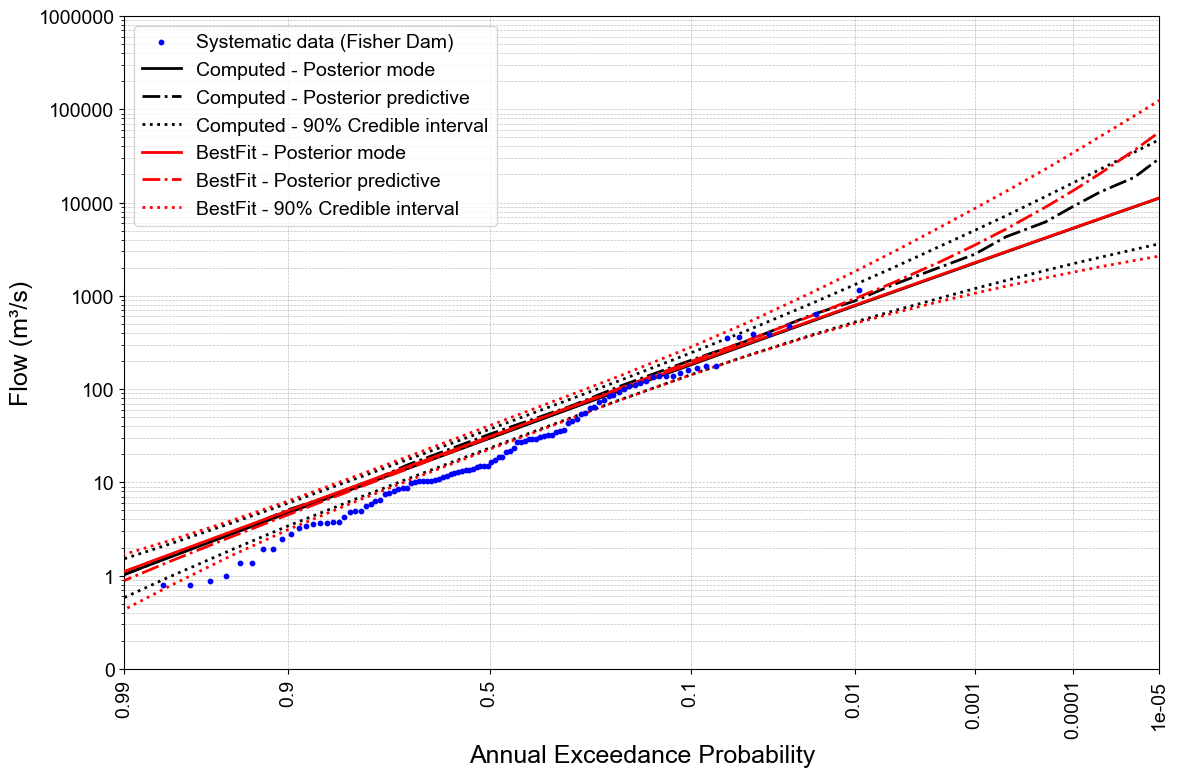

In [69]:
plt.figure(figsize=(12, 8))

plt.scatter(df['zstd'], df['Flow'], 
            s=10, color='blue', label='Systematic data (Fisher Dam)', zorder=10)

plt.plot(x_values_z_scores, flood_quantiles_nslp3_exp, 
         color = "black", linewidth=2,
         label=f"Computed - Posterior mode")

plt.plot(x_values_z_scores, posterior_predictive_exp, 
         color = "black", linestyle='-.', linewidth=2,
         label=f"Computed - Posterior predictive", zorder = 8)

plt.plot(x_values_z_scores, lower_ci_exp, 
         color = "black", linestyle='dotted', linewidth=2,
         label = "Computed - 90% Credible interval")

plt.plot(x_values_z_scores, upper_ci_exp, 
         color = "black", linestyle='dotted', linewidth=2)

plt.plot(bestfit_z_scores, bestfit_mode_exp, 
         color = "red",  linewidth=2,
         label=f"BestFit - Posterior mode", zorder = 9)

plt.plot(bestfit_z_scores, bestfit_predicitive_exp, 
         color = "red", linestyle='-.', linewidth=2,
         label=f"BestFit - Posterior predictive", zorder = 9)

plt.plot(bestfit_z_scores, bestfit_5CI_exp, 
         color = "red", linestyle='dotted', linewidth=2,
         label=f"BestFit - 90% Credible interval", zorder = 9)

plt.plot(bestfit_z_scores, bestfit_95CI_exp, 
         color = "red", linestyle='dotted', linewidth=2, zorder = 9)

# cut off values for major ticks, and their corresponding z-scores
aep_lst = [0.99, 0.9, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001]
major_z_scores = [-norm.ppf(aep) for aep in aep_lst]
x_ticks = [str(aep) for aep in aep_lst]

plt.xticks(major_z_scores, x_ticks, rotation = 90)
plt.grid(which='both', color='grey', linestyle='--', linewidth=0.5, alpha=0.5)

plt.yscale('log')
y_values = [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]
y_ticks = [str(i) for i in y_values]
plt.yticks(y_values, y_ticks)

plt.xlim(major_z_scores[0], major_z_scores[-1])
plt.ylim(y_values[0], y_values[-1])

ax = plt.gca()
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter) 

# set labels for x and y axes
plt.xlabel('Annual Exceedance Probability', fontsize=label_font_size, fontname=font_style)
plt.ylabel("Flow (m³/s)", fontsize=label_font_size, fontname=font_style)
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig(r"C:\ISYE6420\Homework\Project\data\OCD\OCD_bayesian_flood_quantiles_lp3_exponential_mu.png", dpi=300)

## Plot distribution

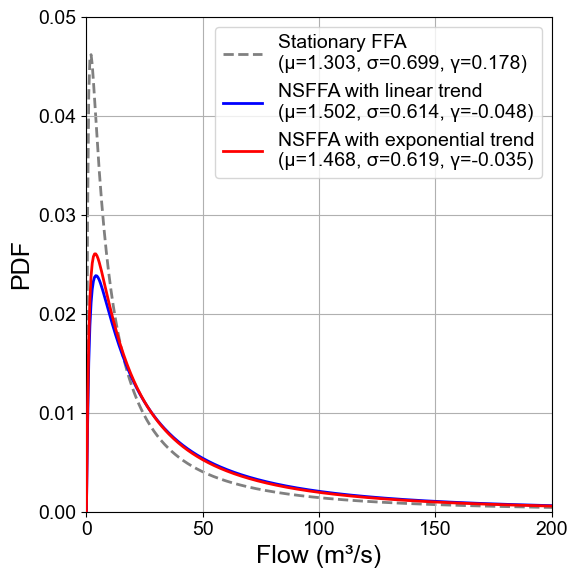

In [70]:

# Plotting the PDF
plt.figure(figsize=(6, 6))
plt.plot(x_values, lp3_pdf_values_s, 
         linestyle="--", color = "grey",  linewidth=2,
         label=f"Stationary FFA \n(μ={mu_slp3:.3f}, σ={sigma_slp3:.3f}, γ={gamma_slp3:.3f})", zorder=1)
plt.plot(x_values, lp3_pdf_values_ns, 
         color = "blue",  linewidth=2,
         label=f"NSFFA with linear trend\n(μ={mu_nslp3:.3f}, σ={sigma_nslp3:.3f}, γ={gamma_nslp3:.3f})", zorder=8)
plt.plot(x_values, lp3_pdf_values_exp, 
         color = "red", linewidth=2,
         label=f"NSFFA with exponential trend\n(μ={mu_exp_nslp3:.3f}, σ={sigma_exp_nslp3:.3f}, γ={gamma_exp_nslp3:.3f})", zorder = 9)

plt.xlim(0, 200)
plt.ylim(0, 0.05)
plt.xlabel("Flow (m³/s)", fontsize=label_font_size, fontname=font_style)
plt.ylabel("PDF", fontsize=label_font_size, fontname=font_style)
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.savefig(r"C:\ISYE6420\Homework\Project\data\OCD\OCD_LP3_nonstationary_comparison.png", dpi=300)

## Plot flood frequency curve

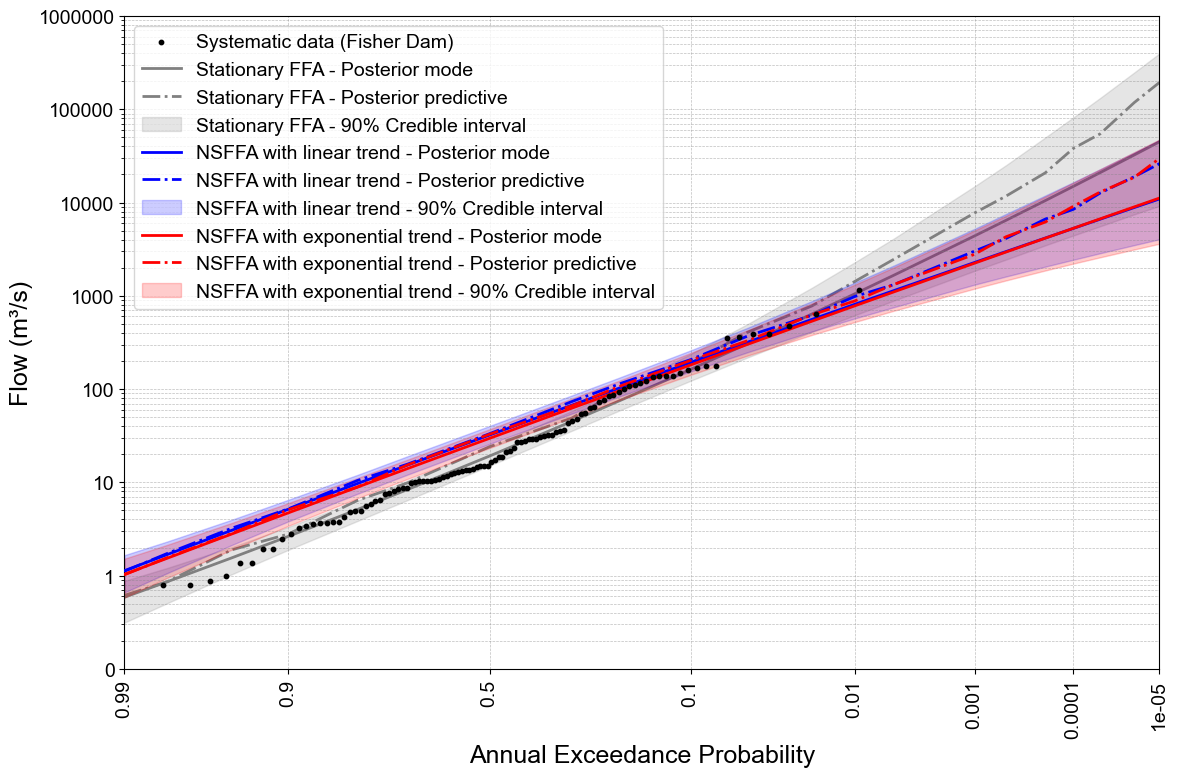

In [71]:
plt.figure(figsize=(12, 8))

plt.scatter(df['zstd'], df['Flow'], 
            s=10, color='black', label='Systematic data (Fisher Dam)', zorder=10)

plt.plot(x_values_z_scores, flood_quantiles_slp3, 
         color = "grey", linewidth=2,
         label=f"Stationary FFA - Posterior mode", zorder = 1)

plt.plot(x_values_z_scores, posterior_predictive_s, 
         color = "grey", linestyle='-.', linewidth=2,
         label=f"Stationary FFA - Posterior predictive", zorder = 1)

plt.fill_between(x_values_z_scores, lower_ci_s, upper_ci_s, color='grey', alpha=0.2,
                 label = "Stationary FFA - 90% Credible interval", zorder = 1)

plt.plot(x_values_z_scores, flood_quantiles_nslp3, 
         color = "blue", linewidth=2,
         label=f"NSFFA with linear trend - Posterior mode", zorder =8)

plt.plot(x_values_z_scores, posterior_predictive, 
         color = "blue", linestyle='-.', linewidth=2,
         label=f"NSFFA with linear trend - Posterior predictive", zorder = 8)

plt.fill_between(x_values_z_scores, lower_ci, upper_ci, color='blue', alpha=0.2,
                 label = "NSFFA with linear trend - 90% Credible interval")

plt.plot(x_values_z_scores, flood_quantiles_nslp3_exp, 
         color = "red",  linewidth=2,
         label=f"NSFFA with exponential trend - Posterior mode", zorder = 9)

plt.plot(x_values_z_scores, posterior_predictive_exp, 
         color = "red", linestyle='-.', linewidth=2,
         label=f"NSFFA with exponential trend - Posterior predictive", zorder = 9)

plt.fill_between(x_values_z_scores, lower_ci_exp, upper_ci_exp, color='red', alpha=0.2,
                    label = "NSFFA with exponential trend - 90% Credible interval")

# cut off values for major ticks, and their corresponding z-scores
aep_lst = [0.99, 0.9, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001]
major_z_scores = [-norm.ppf(aep) for aep in aep_lst]
x_ticks = [str(aep) for aep in aep_lst]

plt.xticks(major_z_scores, x_ticks, rotation = 90)
plt.grid(which='both', color='grey', linestyle='--', linewidth=0.5, alpha=0.5)

plt.yscale('log')
y_values = [0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]
y_ticks = [str(i) for i in y_values]
plt.yticks(y_values, y_ticks)

plt.xlim(major_z_scores[0], major_z_scores[-1])
plt.ylim(y_values[0], y_values[-1])

ax = plt.gca()
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter) 

# set labels for x and y axes
plt.xlabel('Annual Exceedance Probability', fontsize=label_font_size, fontname=font_style)
plt.ylabel("Flow (m³/s)", fontsize=label_font_size, fontname=font_style)
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig(r"C:\ISYE6420\Homework\Project\data\OCD\OCD_bayesian_flood_quantiles_lp3_nonstationary.png", dpi=300)